In this project I'd like to show how I've created fake news classifier with the help of TFIDF and Random Forest models. First I loaded the data, then I cleaned the data and at the same time have made a little exploratory analysis and in the end I created models to predict label of the news.

Loading fake and true news datasets using pandas.

In [1]:
import pandas as pd
import csv
fake = pd.read_csv('Fake.csv', low_memory=False)
true = pd.read_csv('True.csv', low_memory=False)

Let's look at some of the news from the fake dataset.

In [ ]:
fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


And true dataset.

In [ ]:
true.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


**Pre-processing**

I've concatenated both datasets to preprocess the data simoutantly. I've given both datasets the labels which helped during supervised training of the random forest model. I've sampled the data to see the results of concatenation.

In [2]:
fake['label'] = 'fake'
true['label'] = 'true'
data = pd.concat([true, fake], axis=0)
data.sample(frac=1).head()

,title,text,subject,date,label
2002,"Gorka, a Trump adviser and Bannon ally, is out...",WASHINGTON (Reuters) - White House adviser Seb...,politicsNews,"August 26, 2017",true
12970,Kazakh leader tells cabinet: Make state firms ...,ASTANA (Reuters) - Kazakh President Nursultan ...,worldnews,"December 6, 2017",true
4067,Canada says ready to come to NAFTA talks 'at a...,OTTAWA (Reuters) - Canada is ready to come to ...,politicsNews,"April 26, 2017",true
6926,NASA Publicly Humiliates Right-Wing Climate C...,Don t mess with NASA because they will burn yo...,News,"April 13, 2016",fake
3991,U.N. hopes Trump will preach human rights to D...,GENEVA (Reuters) - U.S. President Donald Trump...,politicsNews,"May 1, 2017",true


Having these two datasets concatenated, let's see if the overall news data is balanced, in other words if the datasets have similar amount of records.

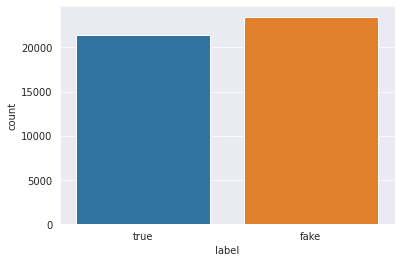

In [15]:
import seaborn as sns
sns.set_style("darkgrid")
sns.countplot(x=data.label)

We can see that the data is quite balanced, the difference is not that significant for that amount of records.

I haven't looked for the relationship between title and text so I've concatenated both columns which gave better results in the end than using only words from the text column (or title column).

In [3]:
data['title with text'] = data['title'] + ' ' + data['text']
data = data[['title with text', 'label']]
data.head()

,title with text,label
0,"As U.S. budget fight looms, Republicans flip t...",true
1,U.S. military to accept transgender recruits o...,true
2,Senior U.S. Republican senator: 'Let Mr. Muell...,true
3,FBI Russia probe helped by Australian diplomat...,true
4,Trump wants Postal Service to charge 'much mor...,true


I've made sure that there are no empty rows which could skew the results.

In [4]:
import numpy as np
np.sum(data.isnull().any(axis=1))

0

I've created two columns, the first one with the length of the 'title with text' column (which in the remaining part of the notebook I will call simply 'text') and the second column with the percentage of punctuation characters in the whole text. I've assumed that fake news are rather shorter than the true ones because they rarely rely on broad description of the events. I'm used to the fact that fake news are also written by less professional writers so they tend to contain less punctuation.

In [5]:
import re
import string

def count_punct(text):
    count = sum([1 for char in text if char in string.punctuation])
    return round(count/(len(text) - text.count(" ")), 3)*100

data['body_len'] = data['title with text'].apply(lambda x: len(x) - x.count(" "))
data['punct%'] = data['title with text'].apply(lambda x: count_punct(x))
data.head()

,title with text,label,body_len,punct%
0,"As U.S. budget fight looms, Republicans flip t...",true,3962,3.1
1,U.S. military to accept transgender recruits o...,true,3509,2.3
2,Senior U.S. Republican senator: 'Let Mr. Muell...,true,2375,2.2
3,FBI Russia probe helped by Australian diplomat...,true,2136,2.5
4,Trump wants Postal Service to charge 'much mor...,true,4400,3.1


I've plotted body length of true and fake news with mean body length.

Text(0.5, 1.0, 'True news')

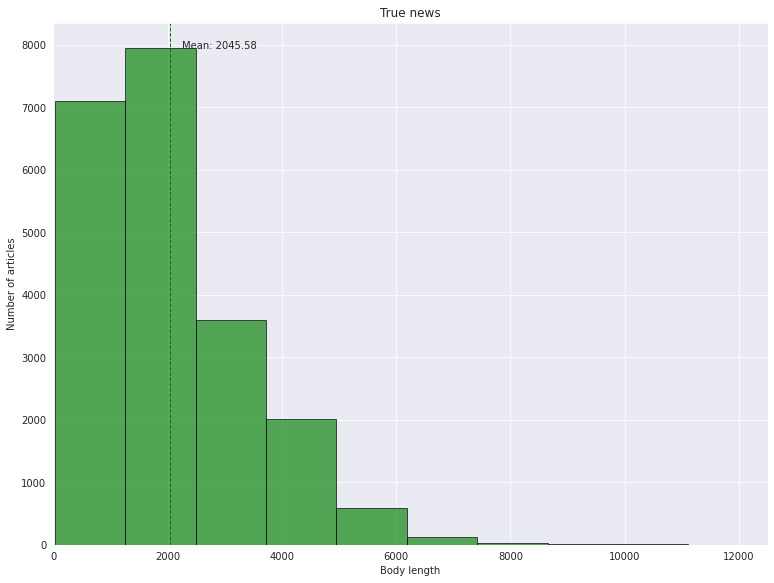

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize = (6.4 * 2, 4.8 * 2))
x_true = data[data.label == 'true']['body_len']
result_true = plt.hist(x_true, bins=20, color='g', edgecolor='k', alpha=0.65)
x_true_mean = x_true.mean()
plt.axvline(x_true_mean, color='g', linestyle='dashed', linewidth=1)
min_ylim, max_ylim = plt.ylim()
plt.text(x_true_mean*1.1, max_ylim*0.95, 'Mean: {:.2f}'.format(x_true_mean))
plt.xlim(0, 12500)
plt.xlabel('Body length')
plt.ylabel('Number of articles')
plt.title('True news')

Text(0.5, 1.0, 'Fake news')

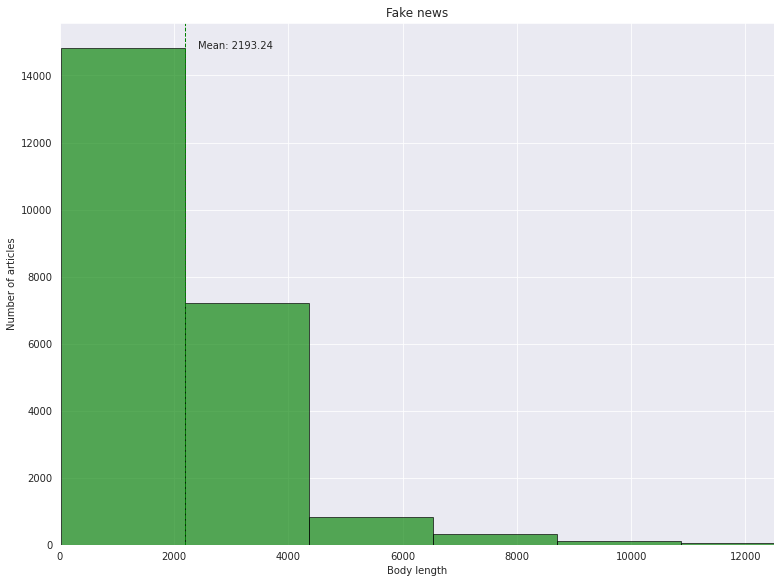

In [ ]:
plt.figure(figsize = (6.4 * 2, 4.8 * 2))
x_fake = data[data.label == 'fake']['body_len']
result_fake = plt.hist(x_fake, bins=20, color='g', edgecolor='k', alpha=0.65)
x_fake_mean = x_fake.mean()
plt.axvline(x_fake_mean, color='g', linestyle='dashed', linewidth=1)
min_ylim, max_ylim = plt.ylim()
plt.text(x_fake_mean*1.1, max_ylim*0.95, 'Mean: {:.2f}'.format(x_fake_mean))
plt.xlim(0, 12500)
plt.xlabel('Body length')
plt.ylabel('Number of articles')
plt.title('Fake news')

As we can see, the results are quite similar, with the mean body length of fake news being slightly bigger. 

I've also plotted percentage of punctuation occurance in true and fake news with mean value.

Text(0.5, 1.0, 'True news')

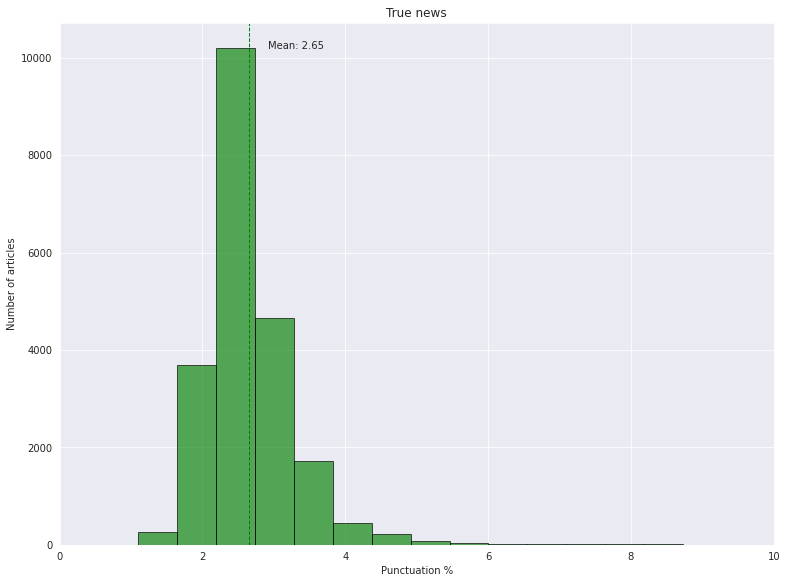

In [ ]:
plt.figure(figsize = (6.4 * 2, 4.8 * 2))
x_true = data[data.label == 'true']['punct%']
result_true = plt.hist(x_true, bins=20, color='g', edgecolor='k', alpha=0.65)
x_true_mean = x_true.mean()
plt.axvline(x_true_mean, color='g', linestyle='dashed', linewidth=1)
min_ylim, max_ylim = plt.ylim()
plt.text(x_true_mean*1.1, max_ylim*0.95, 'Mean: {:.2f}'.format(x_true_mean))
plt.xlabel('Punctuation %')
plt.ylabel('Number of articles')
plt.xlim(0, 10)
plt.title('True news')

Text(0.5, 1.0, 'Fake news')

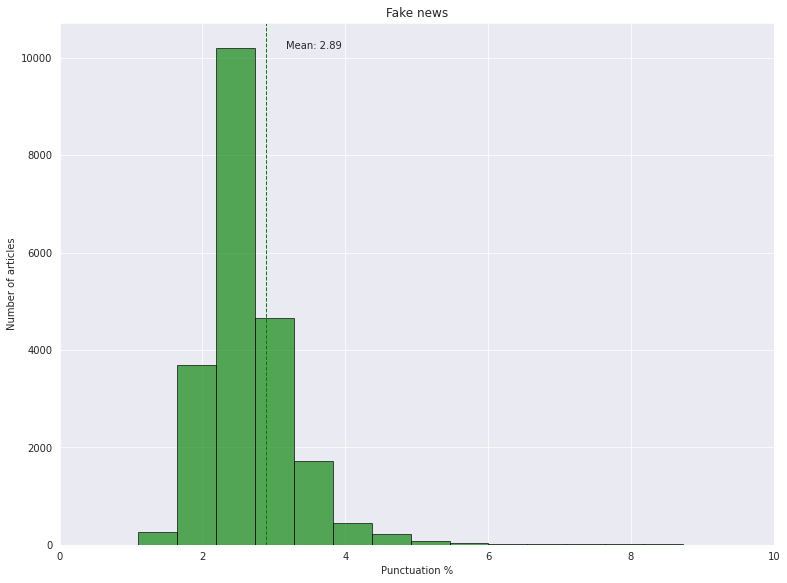

In [ ]:
plt.figure(figsize = (6.4 * 2, 4.8 * 2))
x_fake = data[data.label == 'fake']['punct%']
result_fake = plt.hist(x_true, bins=20, color='g', edgecolor='k', alpha=0.65)
x_fake_mean = x_fake.mean()
plt.axvline(x_fake_mean, color='g', linestyle='dashed', linewidth=1)
min_ylim, max_ylim = plt.ylim()
plt.text(x_fake_mean*1.1, max_ylim*0.95, 'Mean: {:.2f}'.format(x_fake_mean))
plt.xlabel('Punctuation %')
plt.ylabel('Number of articles')
plt.xlim(0, 10)
plt.title('Fake news')

Both comparisons of body length and punctuation % surprised me, because fake news "won" in these both categories which I thought would be an easy win in favour of true news.

Here, I've created a couple of functions which'll help with the further process of preprocessing the text data. Worth explaining here are features from the nltk library which is natural language processing toolkit written in Python. Stopwords are the words which are useless, e.g. words such as 'he', 'the', 'a' etc. PorterStemmer is an algorithm made for removing the commoner morphological and inflexional endings from words in English (e.g. converting plurals to singular). 

In [6]:
def to_lowercase(text):
    return text.lower()

def remove_punctuation(text):
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator)

def remove_twitter_nickname(text):
    return re.sub('@[^\s]+', ' ', text)

def remove_URL(text):
    return re.sub('((www\.[^\s]+)|(https?://[^\s]+)|(bit\.ly\S+))', ' ', text)

def remove_hash(text):
    return re.sub(r'#([^\s]+)', r'\1', text)

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop = set(stopwords.words('english'))

def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i not in stop:
            final_text.append(i.strip())
    return " ".join(final_text)
    
def clean_text(text):
    text = to_lowercase(text)
    text = remove_stopwords(text)
    text = remove_twitter_nickname(text)
    text = remove_URL(text)
    text = remove_hash(text)
    text = remove_punctuation(text)
    return text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Cleaning the text.

In [7]:
data['title with text'] = data['title with text'].apply(clean_text)
data.head()

,title with text,label,body_len,punct%
0,us budget fight looms republicans flip fiscal ...,true,3962,3.1
1,us military accept transgender recruits monday...,true,3509,2.3
2,senior us republican senator let mr mueller jo...,true,2375,2.2
3,fbi russia probe helped australian diplomat ti...,true,2136,2.5
4,trump wants postal service charge much more am...,true,4400,3.1


Below I've created a word cloud with top 100 most used words from the real news dataset. Word cloud is a data visualization technique used for representing text data in which the size of each word indicates its frequency or importance.

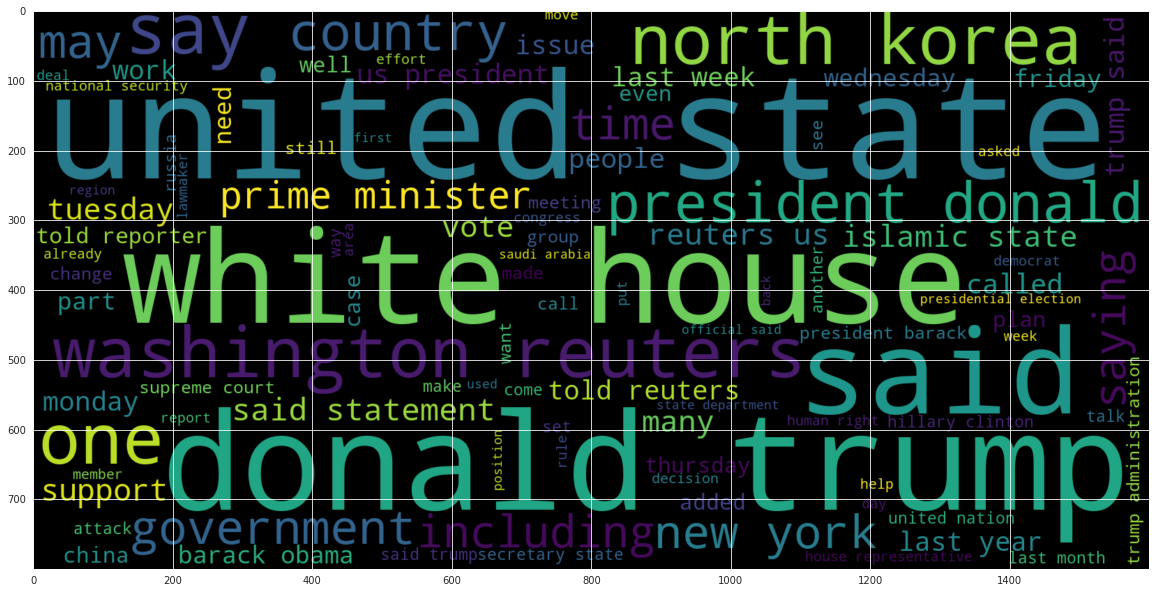

In [ ]:
from wordcloud import WordCloud
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 100, width = 1600, height = 800).generate(" ".join(data[data.label == 'true']['title with text']))
plt.imshow(wc, interpolation = 'bilinear')

And here's a word cloud with top 100 most used words from the fake news dataset.

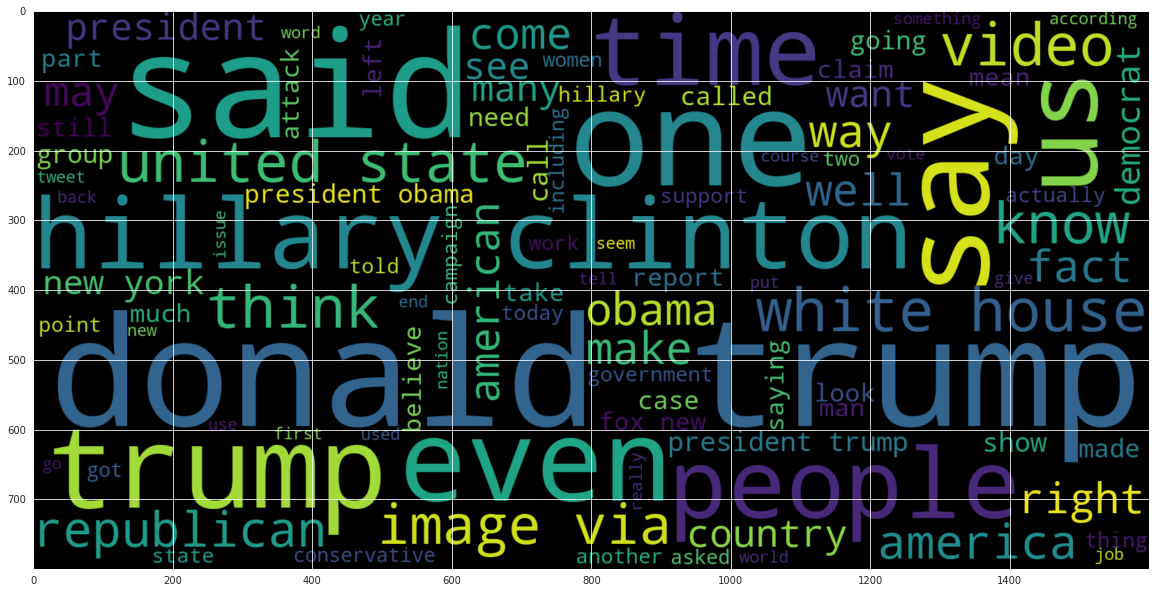

In [ ]:
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 100, width = 1600, height = 800).generate(" ".join(data[data.label == 'fake']['title with text']))
plt.imshow(wc, interpolation = 'bilinear')

As we can see, both word clouds share a lot of common N-grams (an N-gram means a sequence of N words. So for example, "hillary" is a 1-gram (a unigram), "hillary clinton" is a 2-gram (a bigram)). However, they're of different occurence, so the importance changes.

Here, I've used train_test_split function to create random train and test subsets of the dataset.

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data[['body_len', 'punct%', 'title with text']], data['label'], test_size=0.4, random_state=42)

Here I've used TfidfVectorizer to transform the matrix into a tf-idf representation. I had to limit features pool to 10000 because of RAM limitations.

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=10000)
tfidf_fit = tfidf.fit(X_train['title with text'])
tfidf_train = tfidf_fit.transform(X_train['title with text'])
tfidf_test = tfidf.transform(X_test['title with text'])

X_train_vect = pd.concat([X_train[['body_len', 'punct%']].reset_index(drop=True), 
           pd.DataFrame(tfidf_train.toarray())], axis=1)
X_test_vect = pd.concat([X_test[['body_len', 'punct%']].reset_index(drop=True), 
           pd.DataFrame(tfidf_test.toarray())], axis=1)

The random forest is a classification algorithm consisting of many decisions trees. It uses bagging and feature randomness when building each individual tree to try to create an uncorrelated forest of trees whose prediction by committee is more accurate than that of any individual tree.

In [10]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=150, max_depth=None, n_jobs=-1)

rf_model = rf.fit(X_train_vect, y_train)
y_pred = rf_model.predict(X_test_vect)

Let's test how accurate has been the prediction.

In [11]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

0.9971603563474387

The model has achieved accuracy of over 99.7%.

I've alseo calculated probabilities of the news being fake and true and printed first 20 articles with the probabilities.

In [23]:
rating_proba_predictions = rf_model.predict_proba(X_test_vect)
rating_proba_predictions_df = pd.DataFrame(rating_proba_predictions, columns=['Fake %', 'True %']).merge(X_test, left_index=True, right_index=True).reset_index().drop('index', axis=1)
rating_proba_predictions_df.head(20)

,Fake %,True %,body_len,punct%,title with text
0,0.940000,0.060000,2445,5.0,donald trump sends embarrassing new year’s eve...
1,0.940000,0.060000,3962,3.1,us budget fight looms republicans flip fiscal ...
2,0.940000,0.060000,3509,2.3,us military accept transgender recruits monday...
3,0.940000,0.060000,1651,2.4,drunk bragging trump staffer started russian c...
4,0.946667,0.053333,3073,4.8,sheriff david clarke becomes internet joke thr...
5,0.973333,0.026667,4400,3.1,trump wants postal service charge much more am...
6,0.973333,0.026667,1972,2.0,pope francis called donald trump christmas spe...
7,0.093333,0.906667,1490,2.4,racist alabama cops brutalize black boy handcu...
8,0.066667,0.933333,2735,2.4,trump says russia probe fair timeline unclear ...
9,0.080000,0.920000,772,6.7,factbox trump twitter dec 29 approval rating ...


A confusion matrix, also known as an error matrix, is a specific table layout that allows visualization of the performance of an algorithm, typically a supervised learning one. Classification accuracy alone can be misleading if we have an unequal number of observations in each class or if we have more than two classes in your dataset. 

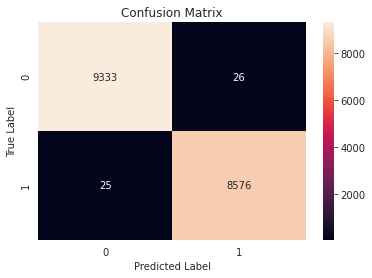

In [18]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
class_label = [0, 1]
df_cm = pd.DataFrame(cm, index=class_label,columns=class_label)
sns.heatmap(df_cm, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

As we can see from the plot, 9333 of fake news have been detected correctly and only 26 of fake news have been falsely classified as true. 8576 of true news have been classified correctly and only 25 falsely.